#### Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint, uniform
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from joblib import dump
import shap

# Scikit-learn Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import RandomizedSearchCV

# Boosting Models
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

C:\Users\CARL JIMROE PANO\miniconda3\envs\IS\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Load the Mental Health dataset based on DASS-21

In [31]:
df = pd.read_csv('DASS.csv', sep=',')
df.rename(columns={
    'Q1_1': 'Age',
     'Q1_2': 'Gender',
     'Q1_3': 'Marital_Status',
     'Q1_4': 'Educational_Status',
     'Q1_5': 'Occupational_Status',
     'Q1_6': 'Sleeping_Problem',
     'Q3_1_S1': 'SQ1',
     'Q3_2_S2': 'SQ2',
     'Q3_3_S3': 'SQ3',
     'Q3_4_S4': 'SQ4',
     'Q3_5_S5': 'SQ5',
     'Q3_6_S6': 'SQ6',
     'Q3_7_S7': 'SQ7',
     'Q3_8_A1': 'AQ8', 
     'Q3_9_A2': 'AQ9',
     'Q3_10_A3': 'AQ10',
     'Q3_11_A4': 'AQ11',
     'Q3_12_A5': 'AQ12',
     'Q3_13_A6': 'AQ13',
     'Q3_14_A7': 'AQ14',
     'Q3_15_D1': 'DQ15',
     'Q3_16_D2': 'DQ16',
     'Q3_17_D3': 'DQ17',
     'Q3_18_D4': 'DQ18',
     'Q3_19_D5': 'DQ19',
     'Q3_20_D6': 'DQ20',
     'Q3_21_D7': 'DQ21',
}, inplace=True)


pd.set_option('display.max_columns', None)
df.drop(columns=['Stress_Score'], inplace=True)
df.head()

,Age,Gender,Marital_Status,Educational_Status,Occupational_Status,Sleeping_Problem,SQ1,SQ2,SQ3,SQ4,SQ5,SQ6,SQ7,Stress_Level,AQ8,AQ9,AQ10,AQ11,AQ12,AQ13,AQ14,Anxiety_Score,Anxiety_Level,DQ15,DQ16,DQ17,DQ18,DQ19,DQ20,DQ21,Depression_Score,Depression_Level
0,21,2,0,4,4,1,3,3,3,3,1,1,2,4,0,0,0,3,0,2,2,7,3,0,3,3,2,3,3,3,17,5
1,18,2,0,4,4,1,3,3,3,3,1,1,2,4,0,0,0,0,2,0,3,5,2,0,2,3,0,0,2,0,7,3
2,40,2,1,2,1,1,3,3,1,2,2,2,1,4,1,1,2,2,1,2,1,10,5,2,1,1,2,2,1,2,11,4
3,24,1,0,4,2,0,3,3,1,2,2,2,1,4,1,1,2,2,1,2,1,10,5,2,1,1,2,2,1,2,11,4
4,50,1,1,2,2,0,3,3,3,2,1,2,3,5,1,0,0,0,2,1,1,5,2,1,0,0,1,2,0,0,4,1


In [32]:
print("Dataset dimension:", df.shape)

Dataset dimension: (1812, 32)


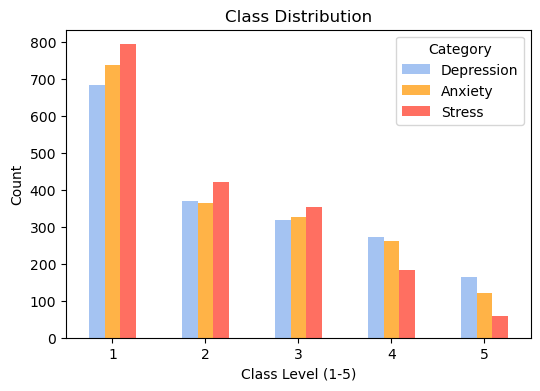

In [10]:
anxiety_counts = df['Anxiety_Level'].value_counts().sort_index()
stress_counts = df['Stress_Level'].value_counts().sort_index()
depression_counts = df['Depression_Level'].value_counts().sort_index()

class_dist_df = pd.DataFrame({
    'Depression': depression_counts,
    'Anxiety': anxiety_counts,
    'Stress': stress_counts
})

class_dist_df.plot(kind='bar', figsize=(6, 4), color=['#A4C3F2', '#FFB347', '#FF6F61'])

plt.title('Class Distribution')
plt.xlabel('Class Level (1-5)')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.legend(title='Category')
plt.show()

In [5]:
# Count each class instances
print(anxiety_counts)
print(stress_counts)
print(depression_counts)

Anxiety_Level
1    739
2    364
3    328
4    261
5    120
Name: count, dtype: int64
Stress_Level
1    794
2    422
3    354
4    183
5     59
Name: count, dtype: int64
Depression_Level
1    684
2    371
3    319
4    273
5    165
Name: count, dtype: int64


In [6]:
# Check for missing data
df.isnull().sum()

Age                    0
Gender                 0
Marital_Status         0
Educational_Status     0
Occupational_Status    0
Sleeping_Problem       0
SQ1                    0
SQ2                    0
SQ3                    0
SQ4                    0
SQ5                    0
SQ6                    0
SQ7                    0
Stress_Score           0
Stress_Level           0
AQ8                    0
AQ9                    0
AQ10                   0
AQ11                   0
AQ12                   0
AQ13                   0
AQ14                   0
Anxiety_Score          0
Anxiety_Level          0
DQ15                   0
DQ16                   0
DQ17                   0
DQ18                   0
DQ19                   0
DQ20                   0
DQ21                   0
Depression_Score       0
Depression_Level       0
dtype: int64

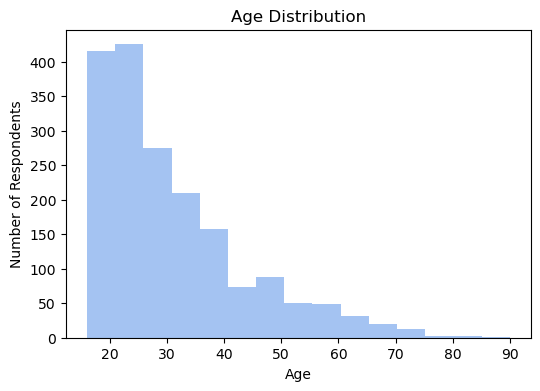

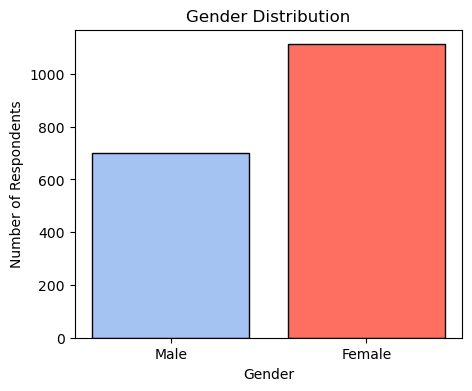

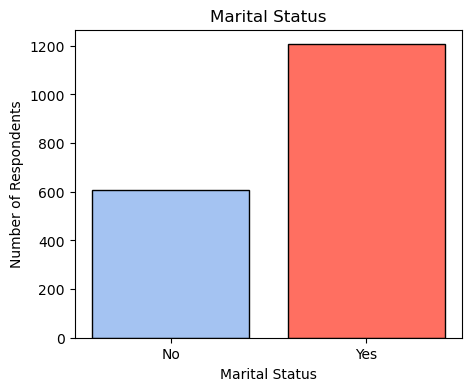

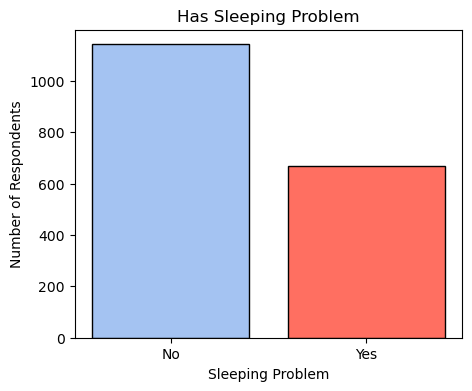

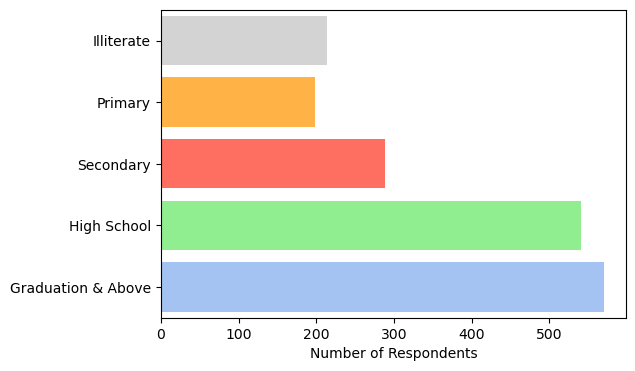

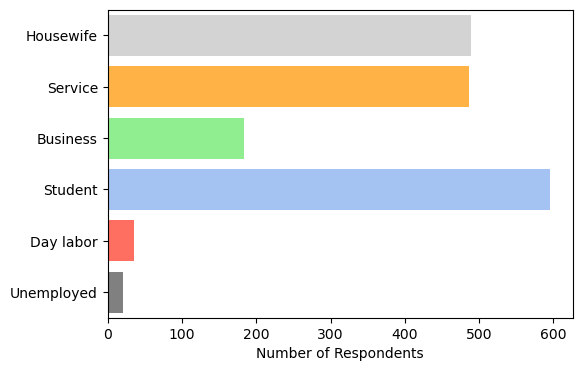

In [43]:
# Exploratory Data Analysis
plt.figure(figsize=(6, 4))
plt.hist(df['Age'], bins=15, color=['#A4C3F2'])
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Number of Respondents')
plt.show()

gender_counts = df['Gender'].value_counts().sort_index() 

plt.figure(figsize=(5, 4))
plt.bar([1, 2], gender_counts, edgecolor='black', color=['#A4C3F2','#FF6F61']) 
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Number of Respondents')
plt.xticks([1, 2], ['Male', 'Female'])
plt.show()

marital_counts = df['Marital_Status'].value_counts().sort_index()  # Assumes No = 0, Yes = 1

# Labels and counts
labels = ['No', 'Yes']
counts = [marital_counts[0], marital_counts[1]]

plt.figure(figsize=(5, 4))
plt.bar(labels, counts, edgecolor='black', color=['#A4C3F2','#FF6F61'])   # You can change the colors
plt.title('Marital Status')
plt.xlabel('Marital Status')
plt.ylabel('Number of Respondents')
plt.show()

sleep_problem_counts = df['Sleeping_Problem'].value_counts().sort_index() 

plt.figure(figsize=(5, 4))
plt.bar([0, 1], sleep_problem_counts, edgecolor='black', color=['#A4C3F2','#FF6F61']) 
plt.title('Has Sleeping Problem')
plt.xlabel('Sleeping Problem')
plt.ylabel('Number of Respondents')
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

df['Education'] = df['Educational_Status'].map({
    1: 'Illiterate', 
    2: 'Primary',
    3: 'Secondary',
    4: 'High School',
    5: 'Graduation & Above'
})

order = ['Illiterate', 'Primary', 'Secondary', 'High School', 'Graduation & Above']
colors = ['lightgray', '#FFB347', '#FF6F61', 'lightgreen', '#A4C3F2']

plt.figure(figsize=(6,4))
ax = sns.countplot(y='Education', data=df, order=order, color='lightgray')  # base color

# Apply custom colors manually
for i, bar in enumerate(ax.patches):
    bar.set_facecolor(colors[i])

ax.set_ylabel('')
plt.xlabel('Number of Respondents')
plt.savefig('education_distribution.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()

######


df['Occupation'] = df['Occupational_Status'].map({
    1: 'Housewife', 
    2: 'Service',
    3: 'Business',
    4: 'Student',
    5: 'Day labor',
    6: 'Unemployed'
})

order = ['Housewife', 'Service', 'Business', 'Student', 'Day labor', 'Unemployed']
colors = ['lightgray', '#FFB347', 'lightgreen', '#A4C3F2', '#FF6F61', 'gray']

plt.figure(figsize=(6,4))
ax = sns.countplot(y='Occupation', data=df, order=order, color='lightgray')  # base color

for i, bar in enumerate(ax.patches):
    bar.set_facecolor(colors[i])

ax.set_ylabel('')
plt.xlabel('Number of Respondents')
plt.savefig('occupation_distribution.png', dpi=300, bbox_inches='tight', transparent=False)
plt.show()


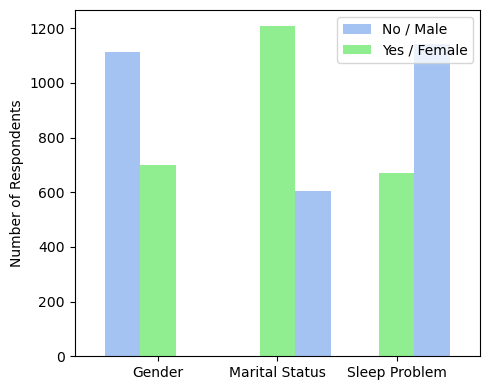

In [42]:
import matplotlib.pyplot as plt
import pandas as pd

demo_summary = {
    'Gender': df['Gender'].value_counts().to_dict(),
    'Marital Status': df['Marital_Status'].value_counts().to_dict(),
    'Sleep Problem': df['Sleeping_Problem'].value_counts().to_dict()
}

demo_df = pd.DataFrame(demo_summary).T

demo_df.plot(
    kind='bar',
    stacked=False,
    color=['#A4C3F2', 'lightgreen'],
    figsize=(5, 4),
    rot=0,         # x labels horizontal
    width=0.9      # increase thickness (default is 0.8)
)

plt.ylabel('Number of Respondents')
plt.legend(['No / Male', 'Yes / Female'])
plt.tight_layout()

plt.savefig('demographic_overview.png', dpi=300, bbox_inches='tight', transparent=False)

plt.show()


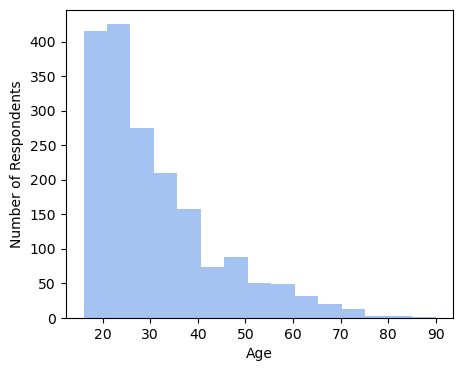

In [45]:
plt.figure(figsize=(5, 4))
plt.hist(df['Age'], bins=15, color='#A4C3F2')
plt.xlabel('Age')
plt.ylabel('Number of Respondents')

plt.savefig('age_dist.png', dpi=300, bbox_inches='tight', transparent=False)

plt.show()

### Boosting Models

In [33]:
# base models
models = {
    'XGBoost': XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='multi:softprob',
        num_class=5,
        eval_metric='mlogloss',
        use_label_encoder=False,
        random_state=42
    ),
    'CatBoost': CatBoostClassifier(
        iterations=500,
        learning_rate=0.05,
        depth=6,
        auto_class_weights='Balanced',
        verbose=0
    ),
    'LightGBM': lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        is_unbalance=True,
        verbose=-1
    )
}

scoring_metrics = {
    'accuracy': 'accuracy',
    'precision': 'precision_weighted',
    'recall': 'recall_weighted',
    'f1': 'f1_weighted'
}

smote = SMOTE(random_state=42)

# hyperparameter search spaces for tuning
param_distributions = {
    'XGBoost': {
        'n_estimators': randint(200, 600),
        'learning_rate': uniform(0.01, 0.1),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    },
    'CatBoost': {
        'iterations': randint(200, 600),
        'learning_rate': uniform(0.01, 0.1),
        'depth': randint(4, 10),
        'l2_leaf_reg': uniform(1, 10)
    },
    'LightGBM': {
        'n_estimators': randint(200, 600),
        'learning_rate': uniform(0.01, 0.1),
        'num_leaves': randint(20, 50),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }
}

In [34]:
def train_and_evaluate(model_dict, X_train, X_test, y_train, y_test, label):
    smote = SMOTE(random_state=42)
    X_res, y_res = smote.fit_resample(X_train, y_train)

    best_model = None
    best_accuracy = 0.0
    best_name = None

    for name, model in model_dict.items():
        print(f"\n=== {name} Model Performance ({label}) ===")
        model.fit(X_res, y_res)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)

        acc = accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, average='weighted')
        rec = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Handle multi-class AUC
        auc = roc_auc_score(
            np.eye(len(np.unique(y_test)))[y_test], 
            y_prob, 
            multi_class='ovr'
        )

        print(f"Accuracy : {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall   : {rec:.4f}")
        print(f"F1-Score : {f1:.4f}")
        print(f"AUC      : {auc:.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, y_pred))

        # Track the best model
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = model
            best_name = name

    print(f"\nBest Model: {best_name} with Accuracy = {best_accuracy:.4f}")
    return best_model, best_name, best_accuracy

### Stress Level Prediction


=== XGBoost Model Performance (Stress) ===
Accuracy : 0.9504
Precision: 0.9518
Recall   : 0.9504
F1-Score : 0.9505
AUC      : 0.9939

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       159
           1       0.99      0.92      0.95        84
           2       0.93      0.92      0.92        71
           3       0.85      0.89      0.87        37
           4       0.86      1.00      0.92        12

    accuracy                           0.95       363
   macro avg       0.92      0.94      0.93       363
weighted avg       0.95      0.95      0.95       363


=== CatBoost Model Performance (Stress) ===
Accuracy : 0.9229
Precision: 0.9263
Recall   : 0.9229
F1-Score : 0.9240
AUC      : 0.9938

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98       159
           1       0.94      0.90      0.92        84
           2       0.90      0.

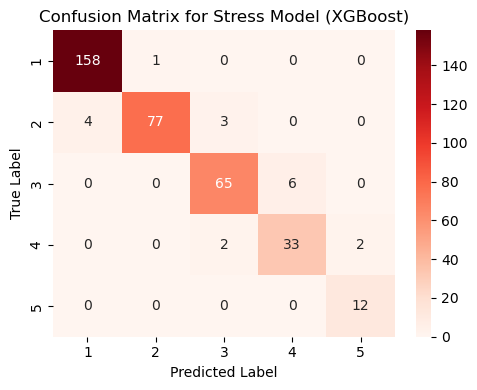

Model saved as stress_model_XGBoost.joblib


In [44]:
# Features (S-Questions 1-7)
X_stress = df[['SQ1', 'SQ2', 'SQ3', 'SQ4', 'SQ5', 'SQ6', 'SQ7']]
y_stress = df['Stress_Level']

y_stress = y_stress.astype(int) -1 #  [1 2 3 4 5] -> [0 1 2 3 4]

X_stress_train, X_stress_test, y_stress_train, y_stress_test = train_test_split(
    X_stress, y_stress, test_size=0.2, random_state=42, stratify=y_stress
)

# =======================
# Train and Evaluate
# =======================
best_model, best_name, best_acc = train_and_evaluate(models, X_stress_train, X_stress_test, y_stress_train, y_stress_test, "Stress")

y_pred = best_model.predict(X_stress_test)

# Shift labels (0–4 → 1–5)
y_true_shifted = y_stress_test + 1
y_pred_shifted = y_pred + 1

# Compute confusion matrix
cm = confusion_matrix(y_stress_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true_shifted, y_pred_shifted, labels=[1,2,3,4,5])

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.title(f"Confusion Matrix for Stress Model ({best_name})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save best model
dump(best_model, f"best_model_{best_name}.joblib")
print(f"Model saved as stress_model_{best_name}.joblib")

### Stress Level Prediction with Hyperparameter Tuning

In [35]:
# run RandomizedSearchCV
best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=20,               # number of random combinations to try
        scoring='accuracy',      # or 'f1_macro', 'roc_auc_ovr', etc.
        cv=5,                    # 5-fold cross-validation
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
    
    search.fit(X_stress_train, y_stress_train)
    
    print(f"Best {name} params: {search.best_params_}")
    print(f"Best {name} CV Score: {search.best_score_:.4f}")
    
    best_models[name] = search.best_estimator_


Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost params: {'colsample_bytree': np.float64(0.6298202574719083), 'learning_rate': np.float64(0.10868869366005172), 'max_depth': 3, 'n_estimators': 335, 'subsample': np.float64(0.602208846849441)}
Best XGBoost CV Score: 0.9551

Tuning CatBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CatBoost params: {'depth': 6, 'iterations': 563, 'l2_leaf_reg': np.float64(6.142344384136116), 'learning_rate': np.float64(0.06924145688620424)}
Best CatBoost CV Score: 0.9600

Tuning LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best LightGBM params: {'colsample_bytree': np.float64(0.7433862914177091), 'learning_rate': np.float64(0.021586905952512975), 'n_estimators': 334, 'num_leaves': 28, 'subsample': np.float64(0.8493192507310232)}
Best LightGBM CV Score: 0.9469


In [39]:
# =======================
# Train and Evaluate
# =======================
train_and_evaluate(best_models, X_stress_train, X_stress_test, y_stress_train, y_stress_test, "Stress")


=== XGBoost Model Performance (Stress) ===
Accuracy : 0.9339
Precision: 0.9369
Recall   : 0.9339
F1-Score : 0.9341
AUC      : 0.9936

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       159
           1       0.97      0.88      0.93        84
           2       0.90      0.86      0.88        71
           3       0.79      0.92      0.85        37
           4       0.86      1.00      0.92        12

    accuracy                           0.93       363
   macro avg       0.90      0.93      0.91       363
weighted avg       0.94      0.93      0.93       363


=== CatBoost Model Performance (Stress) ===
Accuracy : 0.9339
Precision: 0.9369
Recall   : 0.9339
F1-Score : 0.9345
AUC      : 0.9943

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       159
           1       0.96      0.90      0.93        84
           2       0.90      0.

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=np.float64(0.6298202574719083), device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric='mlogloss', feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None,
               learning_rate=np.float64(0.10868869366005172), max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=335, n_jobs=None, num_class=5,
               num_parallel_tree=None, ...),
 'XGBoost',
 0.9338842975206612)

### Anxiety Prediction

In [45]:
# Features (A-Questions 1-7)
X_anxiety = df[['AQ8', 'AQ9', 'AQ10', 'AQ11', 'AQ12', 'AQ13', 'AQ14']]
y_anxiety = df['Anxiety_Level']

y_anxiety = y_anxiety.astype(int) -1

X_anxiety_train, X_anxiety_test, y_anxiety_train, y_anxiety_test = train_test_split(
    X_anxiety, y_anxiety, test_size=0.2, random_state=42, stratify=y_anxiety
)

# =======================
# Train and Evaluate
# =======================
train_and_evaluate(models, X_anxiety_train, X_anxiety_test, y_anxiety_train, y_anxiety_test, "Anxiety")


=== XGBoost Model Performance (Anxiety) ===
Accuracy : 0.9311
Precision: 0.9333
Recall   : 0.9311
F1-Score : 0.9318
AUC      : 0.9901

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.96      0.95      0.95        73
           2       0.91      0.88      0.89        66
           3       0.83      0.83      0.83        52
           4       0.75      0.88      0.81        24

    accuracy                           0.93       363
   macro avg       0.89      0.90      0.90       363
weighted avg       0.93      0.93      0.93       363


=== CatBoost Model Performance (Anxiety) ===
Accuracy : 0.9201
Precision: 0.9249
Recall   : 0.9201
F1-Score : 0.9211
AUC      : 0.9891

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.95      0.96      0.95        73
           2       0.92      

(XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.8, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='mlogloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.05, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=500,
               n_jobs=None, num_class=5, num_parallel_tree=None, ...),
 'XGBoost',
 0.931129476584022)

### Anxiety Prediction with Hyperparameter Tuning

In [46]:
# run RandomizedSearchCV
best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=20,               # number of random combinations to try
        scoring='accuracy',      # or 'f1_macro', 'roc_auc_ovr', etc.
        cv=5,                    # 5-fold cross-validation
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
    
    search.fit(X_anxiety_train, y_anxiety_train)
    
    print(f"Best {name} params: {search.best_params_}")
    print(f"Best {name} CV Score: {search.best_score_:.4f}")
    
    best_models[name] = search.best_estimator_


Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost params: {'colsample_bytree': np.float64(0.9795542149013333), 'learning_rate': np.float64(0.10656320330745593), 'max_depth': 4, 'n_estimators': 464, 'subsample': np.float64(0.6063865008880857)}
Best XGBoost CV Score: 0.9386

Tuning CatBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CatBoost params: {'depth': 6, 'iterations': 563, 'l2_leaf_reg': np.float64(6.142344384136116), 'learning_rate': np.float64(0.06924145688620424)}
Best CatBoost CV Score: 0.9372

Tuning LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best LightGBM params: {'colsample_bytree': np.float64(0.6624074561769746), 'learning_rate': np.float64(0.025599452033620268), 'n_estimators': 530, 'num_leaves': 30, 'subsample': np.float64(0.9464704583099741)}
Best LightGBM CV Score: 0.9186



=== XGBoost Model Performance (Anxiety) ===
Accuracy : 0.9339
Precision: 0.9363
Recall   : 0.9339
F1-Score : 0.9347
AUC      : 0.9885

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.96      0.95      0.95        73
           2       0.92      0.88      0.90        66
           3       0.83      0.85      0.84        52
           4       0.75      0.88      0.81        24

    accuracy                           0.93       363
   macro avg       0.89      0.91      0.90       363
weighted avg       0.94      0.93      0.93       363


=== CatBoost Model Performance (Anxiety) ===
Accuracy : 0.9229
Precision: 0.9276
Recall   : 0.9229
F1-Score : 0.9238
AUC      : 0.9887

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       148
           1       0.95      0.96      0.95        73
           2       0.92      

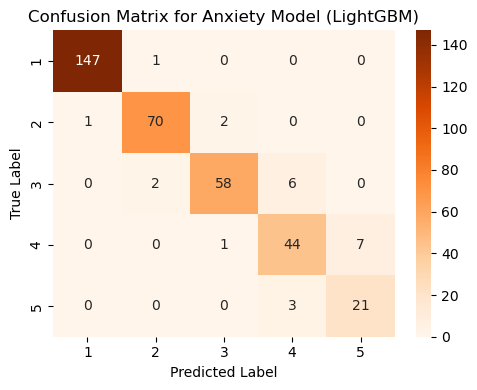

Model saved as anxiety_model_LightGBM.joblib


In [57]:
# =======================
# Train and Evaluate
# =======================
best_model, best_name, best_acc = train_and_evaluate(best_models, X_anxiety_train, X_anxiety_test, y_anxiety_train, y_anxiety_test, "Anxiety")

y_pred = best_model.predict(X_anxiety_test)

# Shift labels (0–4 → 1–5)
y_true_shifted = y_anxiety_test + 1
y_pred_shifted = y_pred + 1

# Compute confusion matrix
cm = confusion_matrix(y_anxiety_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true_shifted, y_pred_shifted, labels=[1,2,3,4,5])

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.title(f"Confusion Matrix for Anxiety Model ({best_name})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save best model
dump(best_model, f"best_model_{best_name}.joblib")
print(f"Model saved as anxiety_model_{best_name}.joblib")

### Depression Prediction

In [35]:
# Features (D-Questions 1-7)
X_depression = df[['DQ15', 'DQ16', 'DQ17', 'DQ18', 'DQ19', 'DQ20', 'DQ21']]
y_depression = df['Depression_Level']

y_depression = y_depression.astype(int) -1

X_depression_train, X_depression_test, y_depression_train, y_depression_test = train_test_split(
    X_depression, y_depression, test_size=0.2, random_state=42, stratify=y_depression
)

# =======================
# Train and Evaluate
# =======================
train_and_evaluate(models, X_depression_train, X_depression_test, y_depression_train, y_depression_test, "Depression")


=== XGBoost Model Performance (Depression) ===
Accuracy : 0.9449
Precision: 0.9446
Recall   : 0.9449
F1-Score : 0.9446
AUC      : 0.9961

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       137
           1       0.94      0.91      0.92        74
           2       0.92      0.89      0.90        64
           3       0.91      0.93      0.92        55
           4       0.97      1.00      0.99        33

    accuracy                           0.94       363
   macro avg       0.94      0.94      0.94       363
weighted avg       0.94      0.94      0.94       363


=== CatBoost Model Performance (Depression) ===
Accuracy : 0.9366
Precision: 0.9368
Recall   : 0.9366
F1-Score : 0.9364
AUC      : 0.9972

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       137
           1       0.92      0.92      0.92        74
           2       0.92

(LGBMClassifier(is_unbalance=True, learning_rate=0.05, n_estimators=500,
                verbose=-1),
 'LightGBM',
 0.9476584022038568)

### Depression Prediction with Hyperparameter Tuning

In [36]:
# run RandomizedSearchCV
best_models = {}

for name, model in models.items():
    print(f"\nTuning {name}...")
    
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=20,               # number of random combinations to try
        scoring='accuracy',      # or 'f1_macro', 'roc_auc_ovr', etc.
        cv=5,                    # 5-fold cross-validation
        random_state=42,
        verbose=1,
        n_jobs=-1
    )
    
    search.fit(X_depression_train, y_depression_train)
    
    print(f"Best {name} params: {search.best_params_}")
    print(f"Best {name} CV Score: {search.best_score_:.4f}")
    
    best_models[name] = search.best_estimator_


Tuning XGBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best XGBoost params: {'colsample_bytree': np.float64(0.9795542149013333), 'learning_rate': np.float64(0.10656320330745593), 'max_depth': 4, 'n_estimators': 464, 'subsample': np.float64(0.6063865008880857)}
Best XGBoost CV Score: 0.9462

Tuning CatBoost...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best CatBoost params: {'depth': 5, 'iterations': 464, 'l2_leaf_reg': np.float64(1.159662522202142), 'learning_rate': np.float64(0.0330893825622149)}
Best CatBoost CV Score: 0.9662

Tuning LightGBM...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best LightGBM params: {'colsample_bytree': np.float64(0.7433862914177091), 'learning_rate': np.float64(0.021586905952512975), 'n_estimators': 334, 'num_leaves': 28, 'subsample': np.float64(0.8493192507310232)}
Best LightGBM CV Score: 0.9469



=== XGBoost Model Performance (Depression) ===
Accuracy : 0.9559
Precision: 0.9559
Recall   : 0.9559
F1-Score : 0.9558
AUC      : 0.9969

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       137
           1       0.95      0.96      0.95        74
           2       0.92      0.89      0.90        64
           3       0.91      0.93      0.92        55
           4       0.97      1.00      0.99        33

    accuracy                           0.96       363
   macro avg       0.95      0.95      0.95       363
weighted avg       0.96      0.96      0.96       363


=== CatBoost Model Performance (Depression) ===
Accuracy : 0.9366
Precision: 0.9370
Recall   : 0.9366
F1-Score : 0.9367
AUC      : 0.9970

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       137
           1       0.92      0.92      0.92        74
           2       0.89

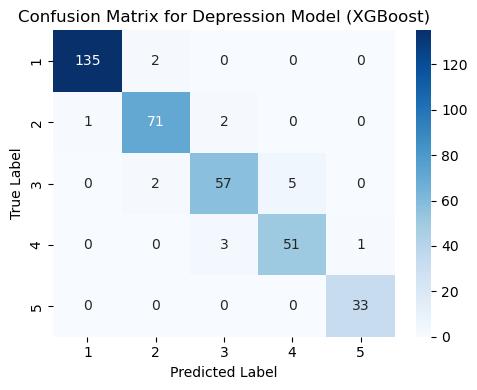

Model saved as depression_model_XGBoost.joblib


In [40]:
# =======================
# Train and Evaluate
# =======================
best_model, best_name, best_acc = train_and_evaluate(best_models, X_depression_train, X_depression_test, y_depression_train, y_depression_test, "Depression")

y_pred = best_model.predict(X_depression_test)

y_true_shifted = y_depression_test + 1
y_pred_shifted = best_model.predict(X_depression_test) + 1

# Compute confusion matrix
cm = confusion_matrix(y_depression_test, y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true_shifted, y_pred_shifted, labels=[1,2,3,4,5])

# Plot
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[1,2,3,4,5],
            yticklabels=[1,2,3,4,5])
plt.title(f"Confusion Matrix for Depression Model ({best_name})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Save best model
dump(best_model, f"best_model_{best_name}.joblib")
print(f"Model saved as depression_model_{best_name}.joblib")

## Feature Importance Analysis

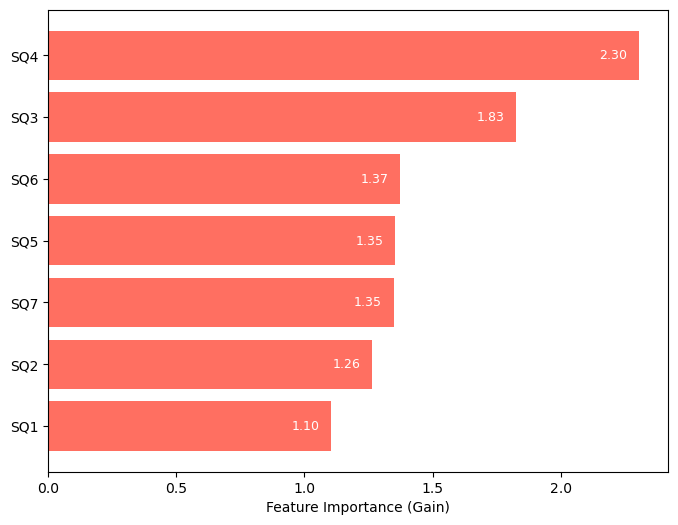

In [26]:
# Load the saved model
stress_model = load("Stress_Model_XGBoost.joblib")

# Get feature importance values (gain) 
importance_dict = stress_model.get_booster().get_score(importance_type='gain')

features = np.array(list(importance_dict.keys()))
values = np.array(list(importance_dict.values()))

sorted_idx = np.argsort(values)[::-1]
features = features[sorted_idx]
values = values[sorted_idx]

plt.figure(figsize=(8,6))
bars = plt.barh(features, values, color='#FF6F61')
plt.xlabel("Feature Importance (Gain)")

# Place the score inside the bar at the tip
for bar, value in zip(bars, values):
    plt.text(
        x=bar.get_width() - (0.02 * max(values)),  # slightly before the tip
        y=bar.get_y() + bar.get_height() / 2,
        s=f'{value:.2f}',
        va='center',
        ha='right',
        color='white',
        fontsize=9
    )

plt.gca().invert_yaxis()

plt.savefig('stress_feature_importance.png', dpi=300, bbox_inches='tight', transparent=False)

plt.show()


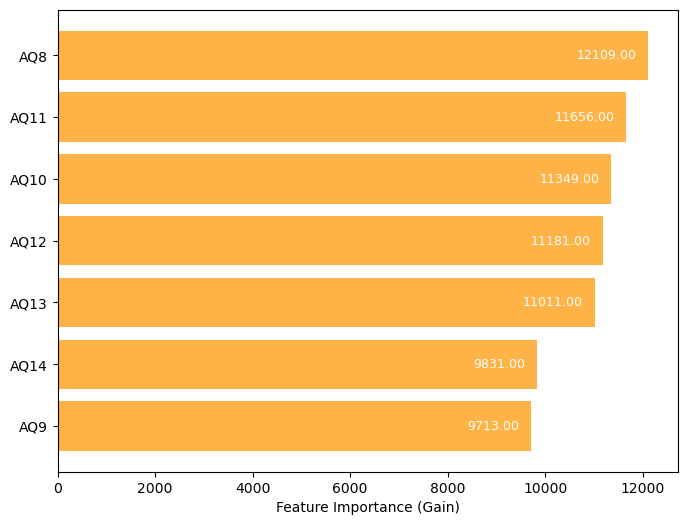

In [27]:
# Load the saved model
anxiety_model = load("Anxiety_Model_LightGBM.joblib")

values = anxiety_model.feature_importances_
features = np.array(anxiety_model.feature_name_)

sorted_idx = np.argsort(values)[::-1]
features = features[sorted_idx]
values = values[sorted_idx]

plt.figure(figsize=(8,6))
bars = plt.barh(features, values, color='#FFB347')
plt.xlabel("Feature Importance (Gain)")

# Place the score inside the bar at the tip
for bar, value in zip(bars, values):
    plt.text(
        x=bar.get_width() - (0.02 * max(values)),  # slightly before the tip
        y=bar.get_y() + bar.get_height() / 2,
        s=f'{value:.2f}',
        va='center',
        ha='right',
        color='white',
        fontsize=9
    )

plt.gca().invert_yaxis()

plt.savefig('anxiety_feature_importance.png', dpi=300, bbox_inches='tight', transparent=False)

plt.show()


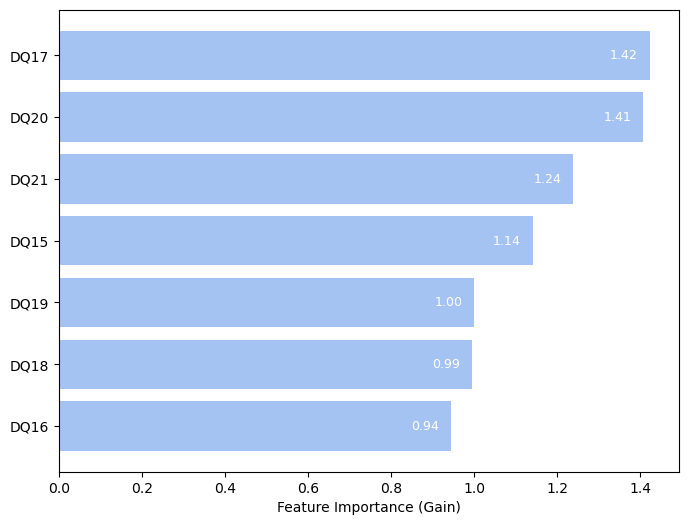

In [2]:
from joblib import load
import matplotlib.pyplot as plt

# Load the saved model
depression_model = load("Depression_Model_XGBoost.joblib")

# Get feature importance values (gain)
importance_dict = depression_model.get_booster().get_score(importance_type='gain')

features = np.array(list(importance_dict.keys()))
values = np.array(list(importance_dict.values()))

sorted_idx = np.argsort(values)[::-1]
features = features[sorted_idx]
values = values[sorted_idx]

plt.figure(figsize=(8,6))
bars = plt.barh(features, values, color='#A4C3F2')
plt.xlabel("Feature Importance (Gain)")

# Place the score *inside* the bar at its tip
for bar, value in zip(bars, values):
    plt.text(
        x=bar.get_width() - (0.02 * max(values)),   # slightly before the tip
        y=bar.get_y() + bar.get_height() / 2,
        s=f'{value:.2f}',
        va='center',
        ha='right',  # align text to the right so it stays clean inside the bar
        color='white',  # white text looks clean inside colored bars
        fontsize=9
    )

plt.gca().invert_yaxis()

plt.savefig('depression_feature_importance.png', dpi=300, bbox_inches='tight', transparent=False)

plt.show()
